In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code_reg_and_clas"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)
    
from utilis.callbacks import Visualise_learning_reg_and_class

# Data Generator

In [4]:
class DataGenerator(keras.utils.Sequence):
    """ Loads, downsamples, crops, and auguments images and labels """
    
    def __init__(self, npz_file_IDs, batch_size=8, dim=(256,512), num_regions=20, shuffle=True, num_crops=1):

        self.npz_file_IDs = npz_file_IDs
        self.batch_size = batch_size
        self.dim = dim
        self.num_regions = num_regions
        self.shuffle = shuffle
        self.on_epoch_end()
        self.num_crops = num_crops

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.npz_file_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def load_data(self, npz_file_ID_temp):
        """ Load .npz files with images and labels from self.room_dir """
        images = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        local_scene_coords = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        region_labels = np.empty((self.batch_size, *self.dim, 1), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.dim, 1), dtype=np.int16)

        for i, ID in enumerate(npz_file_ID_temp):
            npz_data = np.load(ID)
            
            images[i] = npz_data['image_colors']
            local_scene_coords[i] = npz_data['local_scene_coords']
            region_labels[i] = np.expand_dims(npz_data['points_region_class'], axis=-1)
            masks[i] = np.expand_dims(npz_data['mask'], axis=-1).astype(int)

        return images, local_scene_coords, region_labels, masks

    
    def crop(self, data, start_row, start_col, data_depth):
        """ Images are equirectangular (360 projected onto a rectangle).
        Therefore we have to allow for all possibe crops, including these that run across the right image edge. """

        data_croped = np.zeros((self.batch_size, 224, 224, data_depth))

        for ind in range(self.batch_size):

            if start_col[ind] + 224 > 512:
                dif = start_col[ind] + 224 - 512
                wraped_data = data[ind, start_row[ind]:start_row[ind]+224, :dif,:]
                
                data_croped[ind] = np.concatenate(
                    (data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], 
                        wraped_data), axis=1)
                               
            else:
                data_croped[ind] = data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]

        return data_croped
    
    
    def get_crops(self, images, coords, regions, mask):
        
        # pick the start cordinates of croped images
#         start_row = [0] 
        start_row = np.random.randint(0, high=self.dim[0]-224, size=self.batch_size)
#         start_col = [50]
        start_col = np.random.randint(0, high=self.dim[1], size=self.batch_size)
        
        image_crops = self.crop(images, start_row, start_col, data_depth=3)
        coords_crops = self.crop(coords, start_row, start_col, data_depth=3)
        region_crops = self.crop(regions, start_row, start_col, data_depth=1)
        mask_crops = self.crop(mask, start_row, start_col, data_depth=1)
        
        return image_crops, coords_crops, region_crops, mask_crops
    
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.npz_file_IDs) / self.batch_size))
    
     
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.npz_file_IDs[k] for k in indexes]

        # load
        images, local_scene_coords, region_labels, masks = self.load_data(list_IDs_temp)

        # crop
        images, local_scene_coords, region_labels, masks = self.get_crops(images, local_scene_coords, region_labels, masks)

        
        # one-hot encode labels
#         region_labels = (np.arange(self.num_regions) == region_labels[:,:,:,0][...,None]).astype(int)


        # expand dimension of mask
        nested_masks = [masks for _ in range(3)]
        mask_expanded = np.concatenate(nested_masks, axis=-1)

        # apply mask to 3D coords ground truth data
        local_scene_coords = local_scene_coords * mask_expanded
                               
        # coccatenate to images
        labels = np.concatenate((local_scene_coords, region_labels), axis=-1)

        return [images, mask_expanded], labels

In [5]:
dataset_size = 370
val_split = 0.1
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_complete_working_141_classes/"

data_partition = {'train': [],
                'validation': []}

indexes = np.arange(1,dataset_size + 1)
np.random.shuffle(indexes)
split_index = int(val_split*dataset_size)

for ind in indexes[split_index:]:
    coord_npz = f"{ind:04}_rendered.png_config.npz"
    data_partition['train'].append(data_dir + coord_npz)

for ind in indexes[:split_index]:
    coord_npz = f"{ind:04}_rendered.png_config.npz"
    data_partition['validation'].append(data_dir + coord_npz)

In [6]:
generator_configs = {'batch_size': 10, 
                     'dim': (256,512),
                     'num_regions': 141, 
                     'shuffle': True, 
                     'num_crops': 1}

# data_partition = {'train': ["/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_complete_working_141_classes/0001_rendered.png_config.npz"]}

train_generator = DataGenerator(data_partition['train'], **generator_configs)

# MSE callback

In [7]:
class pixelwise_MSE(keras.callbacks.Callback):
    def __init__(self, datapoint_name, frequency, start_row=[0], start_col=[50]):
        super(pixelwise_MSE, self).__init__()
        
        data = self.load_data(datapoint_name, start_row, start_col)
        
        self.image = data['image']
        self.oracle_global_coords = data['points_3d_world']  # i will use this to check whether i'm converting the data correctly
        self.mask = data['mask']
        self.W_inv = data['W_inv']
        self.M = data['M']
        self.std = data['std']
        
        self.frequency = frequency
        
        
      
    def crop(self, data, start_row, start_col, data_depth):
        num_crops = len(start_row)
        data_croped = np.zeros((num_crops, 224, 224, data_depth))

        for ind in range(num_crops):
            if start_col[ind] + 224 > 512:
                dif = start_col[ind] + 224 - 512
                wraped_data = data[ind, start_row[ind]:start_row[ind]+224, :dif,:]
                
                data_croped[ind] = np.concatenate(
                    (data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], 
                        wraped_data), axis=1)  
            else:
                data_croped[ind] = data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]

        return data_croped
    
    
    def load_data(self, data_filename, start_row, start_col):
        data = np.load(data_filename)

        image = self.crop(  np.expand_dims(data['image_colors'], axis=0), start_row, start_col, 3)
        points_3d_world = self.crop(  np.expand_dims(data['points_3d_world'], axis=0), start_row, start_col, 3)
        mask = self.crop(  np.expand_dims(data['mask'], axis=[0,-1]), start_row, start_col, 1)
        
        W_inv = data['W_inv']
        M = data['M']
        std = data['std']
        
        
        return {'image': image,
                'points_3d_world': points_3d_world, 
                'mask': mask,
                'W_inv': W_inv,
                'M': M, 
                'std': std}
    
        
    def on_epoch_begin(self, epoch, logs=None):
        if(epoch%self.frequency == 0):

            output = self.model.predict([self.image, self.mask])
            global_coords = np.zeros((224*224,3))
            
            # 1. convert regions to their mean centers
            pred_local_coords = np.reshape(output[:,:,:,:3], (-1,3))
            labels = np.argmax(output[:,:,:,3:], axis=-1)
            pred_regions = np.reshape(labels, (-1)).astype(int)
                       
          
            # 2. unwhitten local coordinates
            for region in np.unique(pred_regions):
                region_coords = pred_local_coords[pred_regions == region]
                unwhite_loc_coords = np.dot(region_coords * self.std[region] , self.W_inv[region]) + self.M[region]
                
                global_coords[pred_regions == region] = unwhite_loc_coords
            
           
            # 4. compute MSE
            global_coords = np.reshape(global_coords, (224,224,3))
            global_coords = global_coords * self.mask[0]
            oracle = self.oracle_global_coords[0] * self.mask[0]
            errors_squared = np.square(oracle - global_coords)
            euc_dist = np.mean(np.square(oracle - global_coords), axis=-1)
            print('MSE: ', np.mean(euc_dist))
            
            # 5. compute MSE 90th percentile
            percentile_90th = np.percentile(errors_squared, 90)
            euc_dist_perc_90th = np.mean(errors_squared[errors_squared < percentile_90th])
            print('MSE 90th percentile: ', np.mean(euc_dist_perc_90th))
            
            
            # 6. plot for visualisation
            if(epoch%20 == 0):
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))
                region_centers = self.M[pred_regions]
                max_ = max(self.oracle_global_coords[0].max(), global_coords.max())
                min_ = min(self.oracle_global_coords[0].min(), global_coords.min())

                oracle_coords_norm = (self.oracle_global_coords[0] - min_) / (max_ - min_)
                ax1.imshow(oracle_coords_norm)
                ax1.set_title("Ground truth - global scene coords")

                pred_coords_norm = (global_coords - min_) / (max_ - min_)
                ax2.imshow(pred_coords_norm)
                ax2.set_title("Pred - global scene coords")

                region_centers = np.reshape(region_centers, (224,224,3))
    #             reg_cent_norm = (region_centers - min_) / (max_ - min_)
                ax3.imshow(region_centers)

                im4 = ax4.imshow(euc_dist)
                ax4.set_title("Euclidean distance")

                divider = make_axes_locatable(ax4)
                cax = divider.append_axes('right', size='5%', pad=0.1)
                cbar = fig.colorbar(im4, cax=cax)

                plt.show()
            

# Loss func

In [8]:
def combined_loss(y_true, y_pred):
    " combined loss for 3D local coordinate regression and Classification"

    beta = 0.5
    
    regr_true = y_true[:,:,:,:3]
    clas_true = y_true[:,:,:,3:]    
    regr_pred = y_pred[:,:,:,:3]
    clas_pred = y_pred[:,:,:,3:]

    regr_loss = tf.keras.losses.mean_squared_error(regr_true, regr_pred)
    regr_loss = tf.reduce_mean(regr_loss)

#     clas_loss = tf.keras.losses.categorical_crossentropy(clas_true, clas_pred)  # 1-hot-encoded labels
    clas_loss = tf.keras.losses.sparse_categorical_crossentropy(clas_true, clas_pred)  # categorical labels 
    clas_loss = tf.reduce_mean(clas_loss)
    
    loss = 1*regr_loss + 1*clas_loss
    return loss


def combined_loss_multiple_heads(weights=[1,1], num_heads=5):
    " num_heads defines the number of softmax heads the model outputs "
    reg_weight = weights[0] / np.sum(weights)
    clas_weight = weights[1] / np.sum(weights)
    
    def combined_loss(y_true, y_pred):
        " combined loss for 3D local coordinate regression and Classification"

        # REGRESSION
        regr_true = y_true[:,:,:,:3]
        regr_pred = y_pred[:,:,:,:3]
        
        regr_loss = tf.keras.losses.mean_squared_error(regr_true, regr_pred)
        regr_loss = tf.reduce_mean(regr_loss)
                    
            
        # CLASSIFICATION
        clas_losses = []
        for i in range(num_heads):
            clas_true = y_true[:,:,:, 3:]    
            clas_pred = y_pred[:,:,:, 141*i+3 : 141*(i+1)+3]

            clas_loss_tmp = tf.keras.losses.sparse_categorical_crossentropy(clas_true, clas_pred)  # categorical labels 
            clas_loss_tmp = tf.reduce_mean(clas_loss_tmp)
            clas_losses.append(clas_loss_tmp)
        
        clas_loss = tf.reduce_mean(clas_losses)

        loss = reg_weight*regr_loss + clas_weight*clas_loss
        return loss
    
    
    return combined_loss

# Setup model

In [9]:
# from models.unet_resnet_compat import vgg_unet

# unet_model = vgg_unet(num_regions=141)
# unet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=combined_loss)

In [10]:
from models.fpn import resnet_fpn
num_heads = 3

unet_model = resnet_fpn(num_regions=141, num_heads=num_heads)
unet_model.compile(optimizer=keras.optimizers.Adam(5e-4), loss=combined_loss_multiple_heads(weights=[1,1], num_heads=num_heads))

Running: ResNet 18 backbone
Using 3 softmax heads


In [11]:
# unet_model.summary()

# Fit model

In [12]:
[images, mask], labels = train_generator.__getitem__(0)

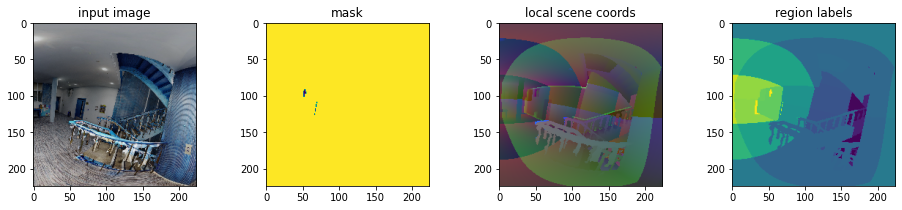

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))

ax1.imshow(images[0])
ax1.set_title("input image")

ax2.imshow(mask[0,:,:,0])
ax2.set_title("mask")

# only use two lines below if input is unnormalised
local_coords_norm = (labels[0,:,:,:3] - labels[0,:,:,:3].min()) / (labels[0,:,:,:3].max() - labels[0,:,:,:3].min())
ax3.imshow(local_coords_norm)
ax3.set_title("local scene coords")

# ax4.imshow(np.argmax(labels[0,:,:,3:], axis=-1))
ax4.imshow(labels[0,:,:,3:])
ax4.set_title("region labels")
plt.show()

In [14]:
np.unique(labels[0,:,:,3:])

array([ 36.,  37.,  38.,  39.,  44.,  45.,  46.,  48.,  61.,  62.,  63.,
        64.,  69.,  70.,  71.,  72.,  79.,  80.,  88.,  89.,  95.,  96.,
       104., 105., 115., 116., 122., 123., 131., 132., 139., 140.])

**Note:** you can see mask on visualisation of local scene coords. The mask has been already applied in the data generator. In prediction visualisation mask will also have been applied in the network.

**Note2:** it is VERY IMPORTANT to have normalised labels. Otherwise it is harder to optimise the model (i wasn't able to train it).

In [15]:
file_name = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_complete_working_141_classes/0001_rendered.png_config.npz"
global_coord_mse_callback = pixelwise_MSE(file_name, 1)
train_vis = Visualise_learning_reg_and_class(images[0], mask[0], labels[0,:,:,:3], labels[0,:,:,3:], 
                                            10, "/data/cornucopia/jz522/experiments/", "temp_testing", "train/")

callbacks = [train_vis]  #global_coord_mse_callback

In [15]:
fit_configs = {'epochs': 20, 
               'verbose': 1}


history = unet_model.fit(train_generator, **fit_configs) #, callbacks=callback  callbacks=[callbacks],
# history = unet_model.fit([images, mask], labels, callbacks=[callbacks], **fit_configs) #, callbacks=callback

Epoch 1/20
33/33 [==============================] - 21s 631ms/step - loss: 3.0130
Epoch 2/20
33/33 [==============================] - 18s 554ms/step - loss: 2.6770
Epoch 3/20
33/33 [==============================] - 19s 585ms/step - loss: 2.4840
Epoch 4/20
33/33 [==============================] - 20s 618ms/step - loss: 2.3634
Epoch 5/20
33/33 [==============================] - 20s 601ms/step - loss: 2.2934
Epoch 6/20
33/33 [==============================] - 22s 658ms/step - loss: 2.1730
Epoch 7/20
33/33 [==============================] - 22s 657ms/step - loss: 2.0674
Epoch 8/20
33/33 [==============================] - 19s 574ms/step - loss: 1.9894
Epoch 9/20
33/33 [==============================] - 22s 657ms/step - loss: 1.9309
Epoch 10/20
33/33 [==============================] - 30s 908ms/step - loss: 1.8644
Epoch 11/20
33/33 [==============================] - 19s 565ms/step - loss: 1.7477
Epoch 12/20
33/33 [==============================] - 22s 666ms/step - loss: 1.6848
Epoch 13/20
3

# Evaluate model

In [16]:
label_pred = unet_model.predict([images, mask])

In [17]:
num_heads

3

In [18]:
def get_color_map(regions, colormap=None):
    if colormap == None:
        colromap_dir = "/data/cornucopia/jz522/experiments/model_visualisation/colormap.npy"
        colormap = np.load(colromap_dir)

    reg_flat = np.reshape(regions, (-1)).astype(int)
    colored_regions_flat = colormap[reg_flat]
    colored_regions = np.reshape(colored_regions_flat, (regions.shape[0], regions.shape[1], 3))
    return colored_regions

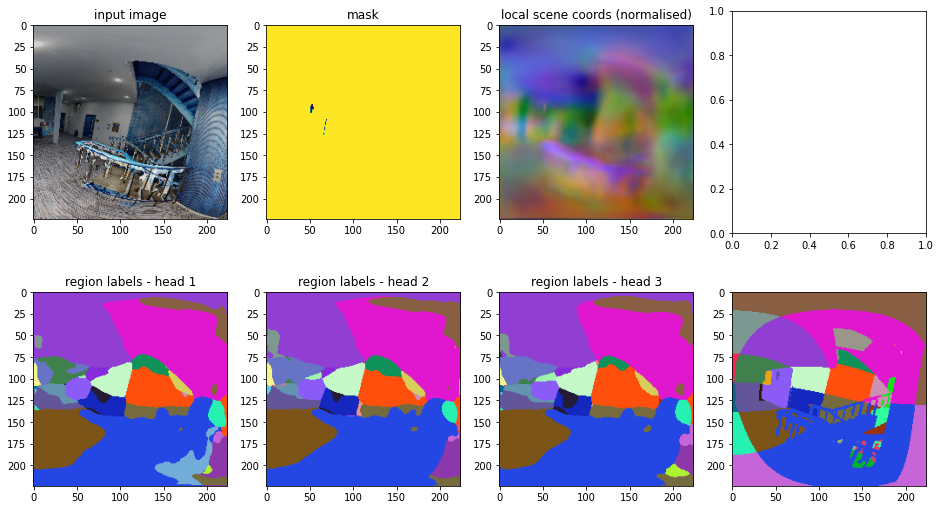

In [19]:
# from utilis.utilis import get_color_map

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16,9))

ax1.imshow(images[0])
ax1.set_title("input image")

ax2.imshow(mask[0,:,:,0])
ax2.set_title("mask")

tmp = (label_pred[0,:,:,:3] - label_pred[0,:,:,:3].min()) / (label_pred[0,:,:,:3].max() - label_pred[0,:,:,:3].min())
ax3.imshow(tmp)
ax3.set_title("local scene coords (normalised)")

for ax, i in zip([ax5, ax6, ax7], range(num_heads)):
    ax.imshow(get_color_map(np.argmax(label_pred[0,:,:,141*i+3 : 141*(i+1)+3], axis=-1)))
    ax.set_title(f"region labels - head {i+1}")

GT_colored_regions = get_color_map(labels[0,:,:,3])
ax8.imshow(GT_colored_regions)
plt.show()

head 0 error:  0.5674
head 1 error:  0.6004
head 2 error:  0.5975


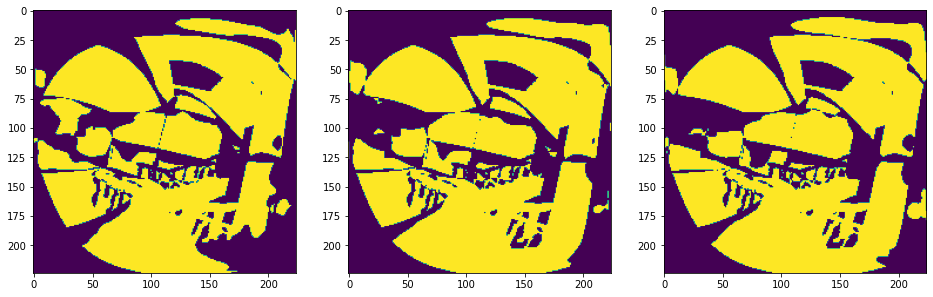

(224, 224)
mean error:  0.5884


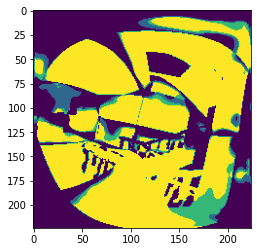

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))

means = []
for i,ax in zip(range(3), [ax1,ax2,ax3]):
    difference = np.argmax(label_pred[0,:,:,141*i+3 : 141*(i+1)+3], axis=-1) - labels[0,:,:,3]
    difference = np.where(difference != 0, 0, 1)
    means.append(difference)
    
    print(f"head {i} error: ", np.round(np.mean(difference),4))
    ax.imshow(difference)
plt.show()
mean_difference = np.mean(np.stack(means, axis=-1), axis=-1)
print(mean_difference.shape)
plt.imshow(mean_difference)
print("mean error: ", np.round(np.mean(mean_difference),4))


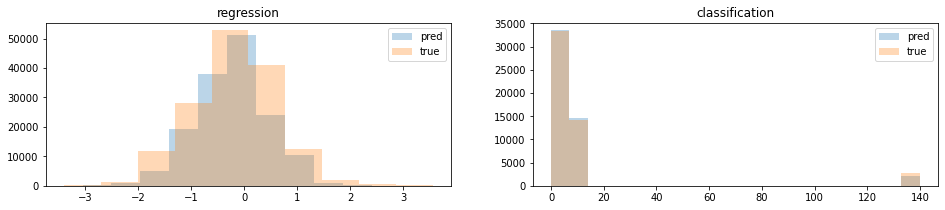

In [124]:
# visualise distribution of TRUE and PRED
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))

ax1.hist(np.reshape(label_pred[0,:,:,:3], (-1)), label="pred", alpha=0.3)
ax1.hist(np.reshape(labels[0,:,:,:3], (-1)), label="true", alpha=0.3)
ax1.set_title('regression')
ax1.legend()

ax2.hist(np.reshape(np.argmax(label_pred[0,:,:,3:], axis=-1), (-1)), label="pred", alpha=0.3, bins=20)
# ax2.hist(np.reshape(np.argmax(labels[0,:,:,3:], axis=-1), (-1)), label="true", alpha=0.3)
ax2.hist(np.reshape(labels[0,:,:,3:], (-1)), label="true", alpha=0.3, bins=20)
ax2.set_title('classification')
ax2.legend()
plt.show()

# Unwhiten predicted coordinates

# Predict pose

# Debugging code

### getting outputs of individual layers

In [ ]:
extractor = keras.Model(inputs=unet_model.inputs,
                        outputs=[unet_model.output for layer in unet_model.layers])

In [ ]:
output = extractor(images)
output[-1].numpy()[0,0,0,:]

### test loss function utside of NN

In [55]:
gen_mask_ = np.expand_dims(gen_mask, axis=-1)
gen_mask_.shape

(1, 224, 224, 1)

In [71]:
labels_pred = np.zeros((1,224,224,8))
labels_pred[:,:,:,:] = 1/8

labels_true = np.zeros((1,224,224,8))
labels_true[:,:,:,0] = 1
# mask = np.ones((1,224,224,1))
labels_true = np.concatenate([labels_true, gen_mask_], axis=-1)
labels_true.shape

(1, 224, 224, 9)

In [72]:
a = masked_X_entropy(labels_true, labels_pred)
a.numpy()

tf.Tensor(
[[[2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  ...
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]]], shape=(1, 224, 224), dtype=float64)


array([[[2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        ...,
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154]]])

In [73]:
np.unique(a.numpy())

array([0.        , 2.07944154])

(array([2.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0152e+04]),
 array([0.        , 0.20794415, 0.41588831, 0.62383246, 0.83177662,
        1.03972077, 1.24766493, 1.45560908, 1.66355323, 1.87149739,
        2.07944154]),
 <BarContainer object of 10 artists>)

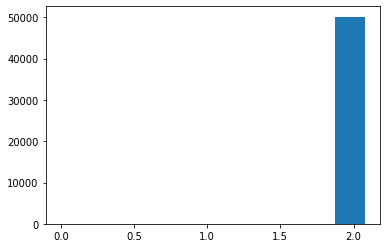

In [74]:
plt.hist(a.numpy().flatten())

In [18]:
tf.keras.losses.categorical_crossentropy(labels_pred, labels_true[:,:,:,:8])

<tf.Tensor: shape=(1, 224, 224), dtype=float64, numpy=
array([[[14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        ...,
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371]]])>

## $\color{red}{\text{CONCLUSION:}}$
### there were 3 errors:

**1. cross entropy outputed 2D matrix rather than scalar** Loss in general should be a scalar. If it's a vector you might compute an update with respect to each element of loss which could grow quicker than for a mean. There would be batch_size*224*224 updates

**2. I was applying softmax function twice** After deleting the first softmax model was fixed. The first softmax could be applied for all nodes 224x224x8 rather than just along the axis=-1

**3. there is some issue with the way i apply the mask** 